# Step 1: Data Ingestion

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import xml.etree.ElementTree as ET
import os
import plotly.express as px

# Read JSON file
def read_json(file_path):
    try: 
        data = pd.read_json(file_path)
        
        # makes it easier for formatting into a table
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"An unexpected error occurred reading JSON file: {e}")
        return None
        

# Read CSV file
def read_csv(file_path):
    try:
        # Making everything read as a string for formatting ease
        df = pd.read_csv(file_path, dtype=str)

        # Making it so that empty cells are replaced with empty strings which will help with formatting
        df.fillna("", inplace=True)
        return df
    except Exception as e:
        print(f"An unexpected error occurred reading CSV file: {e}")
        return None
        

# Read YAML file
def read_yaml(file_path):
    try:
        with open(file_path, 'r') as f:
            data = yaml.safe_load(f)

        # formatting into a table
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"An unexpected error occurred reading YAML file: {e}")
        return None

# Read XML file 
def read_xml(file_path):
    # Parsing through the XML file
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        transactions = [] # Going to use a single list to map every value then convert to dict, multiple lists also works

        for trans in root.findall('transaction'):

            #finding the three main values
            trans_id = trans.attrib.get('id')
            phone = trans.find('phone').text
            store = trans.find('store').text

            for item in trans.find('items').findall('item'):
                item_name = item.find('item').text
                price = item.find('price').text
                price_per_item = item.find('price_per_item').text
                quantity = item.find('quantity').text

                transactions.append({
                    'trans_id': trans_id,
                    'phone': phone,
                    'store': store,
                    'item_name': item_name,
                    'price': price,
                    'price_per_item': price_per_item,
                    'quantity': quantity

                })

        df = pd.DataFrame(transactions)
        return df
    except Exception as e:
        print(f"An unexpected error occurred reading XML file: {e}")
        return None

directory = 'Dataset'
if not os.path.exists(directory):
    os.makedirs(directory)
    
pd.set_option('display.max_columns', None)

# Step 2: Data Matching and Conforming

## Step 2.1: Data Matching .json and .yaml files

The most tedious step of this program. The two files are similar to each other but have different capitalizations, different names for the same thing. We have to consolidate it into one people file that will be used to match the .csv files as well


In [59]:
# Read the files
jsonFile = read_json("data/people.json")
yamlFile = read_yaml("data/people.yml")


# Standardize json final naming
jsonFile.insert(1, 'Name', jsonFile['first_name'] + ' ' + jsonFile['last_name'])
jsonFile.insert(2, 'Phone', jsonFile['telephone'])
jsonFile.insert(3, 'Email', jsonFile['email'])
jsonFile.insert(4, 'Location', jsonFile['location'].apply(lambda x: f"{x['City']}, {x['Country']}"))
jsonFile['Android'] = jsonFile['devices'].apply(lambda x: 'Android' in x)
jsonFile['iPhone'] = jsonFile['devices'].apply(lambda x: 'Iphone' in x)
jsonFile['Desktop'] = jsonFile['devices'].apply(lambda x: 'Desktop' in x)


# Standardizing Yaml to match json
yamlFile['Android'] = yamlFile['Android'].apply(lambda x: True if x == 1 else False)
yamlFile['Iphone'] = yamlFile['Iphone'].apply(lambda x: True if x == 1 else False)
yamlFile['Desktop'] = yamlFile['Desktop'].apply(lambda x: True if x == 1 else False)

#renaming Yaml to match final output
yamlFile.rename(columns={'Iphone': 'iPhone', 'city': 'Location', 'email': 'Email', 'phone': 'Phone', 'name' : 'Name'}, inplace=True)
#renaming the id section to drop leading 0's to match with Yaml ids
jsonFile['id'] = jsonFile['id'].astype(str).str.lstrip('0')
# Dropping the irrelevant columns now
jsonFile.drop(columns=['first_name', 'last_name','location', 'email', 'telephone', 'devices'], inplace=True)

#remapping id from json to integer
jsonFile['id'] = jsonFile['id'].astype(int)

#yamlFile = yamlFile[jsonFile.columns.tolist()]
#merging json and yaml to one file
concatenatedFile = pd.concat([jsonFile, yamlFile], ignore_index=True)

#removing duplicates
finalFile = concatenatedFile.drop_duplicates(subset=['Name', 'id']).reset_index(drop=True)
#print('JSON Columns:', jsonFile.columns)
#print('YAML Columns:', yamlFile.columns)

#print(jsonFile)
#print(concatenatedFile)

#sorting by alphabetical order (note: this is by first name to make it simpler)
finalFile = finalFile.sort_values(by='Name', ignore_index=True)

'''
Test case testing

#checking id exists
id = 5
if id in finalFile['id'].values:
    print(f"ID {id} is in the file.")
else:
    print(f"ID {id} is NOT in the file.")
# Saving it to a CSV file

#checking row of specified id
row = finalFile[finalFile['id'] == id]
print(row)
'''

#Defining path, name and saving
fileName = 'people_data.csv'
filePath = os.path.join(directory, fileName)

print(f"Saving is successful as {fileName} in {directory} folder\n")

finalFile.to_csv(filePath, index=False)

finalFile

Saving is successful as people_data.csv in Dataset folder



,id,Name,Phone,Email,Location,Android,iPhone,Desktop
0,299,Aadam Browning,702-276-7562,Aadam.Browning@example.com,"San Francisco, USA",True,True,True
1,335,Aaminah Daniel,877-314-7868,Aaminah.Daniel@example.com,"New York, USA",True,True,True
2,580,Aayan Donovan,476-401-9860,Aayan.Donovan@example.com,"Paris, France",True,False,True
3,669,Abdirahman Marsh,653-601-4374,Abdirahman.Marsh@example.com,"Toronto, Canada",False,True,False
4,149,Abdirahman Mullen,669-442-8257,Abdirahman.Mullen@example.com,"Toronto, Canada",True,True,True
...,...,...,...,...,...,...,...,...
995,130,Zohaib Hartman,928-400-6426,Zohaib.Hartman@example.com,"Montreal, Canada",False,False,True
996,469,Zohaib Preston,575-540-7871,Zohaib.Preston@example.com,"San Francisco, USA",False,True,False
997,127,Zoya Giles,301-750-7631,Zoya.Giles@example.com,"Toronto, Canada",True,True,False
998,467,Zubair Sheppard,845-425-4523,Zubair.Sheppard@example.com,"San Francisco, USA",True,True,True


## Step 2.2: Data Matching .xml files

This step is a lot simpler, since there isn't really much formatting to do

In [60]:
# Read the xml file
xmlFile = read_xml('data/transactions.xml')

#Capitalize column names to match previous files
xmlFile.columns = xmlFile.columns.str.capitalize()

#Defining path, name, and saving
fileName = 'transactions_data.csv'
filePath = os.path.join(directory, fileName)

print(f"XML saving is successful as {fileName} in {directory} folder\n")

xmlFile.to_csv(filePath, index=False)

xmlFile


XML saving is successful as transactions_data.csv in Dataset folder



,Trans_id,Phone,Store,Item_name,Price,Price_per_item,Quantity
0,1000,233-159-4158,Trader Tales,Krafty Cheddar,5,5,1
1,1000,233-159-4158,Trader Tales,Popsi,4,4,1
2,1000,233-159-4158,Trader Tales,Oreoz,8,4,2
3,1001,725-427-2794,PetPals Mart,Colgatex,2,2,1
4,1002,659-190-9378,Trader Tales,Colgatex,3,3,1
...,...,...,...,...,...,...,...
291,1147,934-954-3387,Urban Outfitters Loft,KittyKat,2,2,1
292,1147,934-954-3387,Urban Outfitters Loft,Colgatex,2,2,1
293,1148,778-566-2709,Trader Tales,Colgatex,3,3,1
294,1148,778-566-2709,Trader Tales,Krafty Cheddar,5,5,1


## Step 2.3: Data Matching transfers.csv files

In [61]:
# Read csv file
transfersFile = read_csv('data/transfers.csv')

#sort the transfers file by id, to make it cleaner
#Display 
transfersFile

,sender_id,recipient_id,amount,date
0,926,531,70.47,2022-01-07
1,280,735,21.88,2022-01-10
2,571,737,44.68,2022-01-13
3,958,945,39.94,2022-01-17
4,373,817,6.98,2022-01-17
...,...,...,...,...
522,487,810,22.60,2024-04-27
523,78,356,30.48,2024-04-27
524,682,888,82.91,2024-04-29
525,463,438,8.80,2024-04-29


In [62]:
#Merge step, to get the sender_name from the consolidated list
transfersFile['sender_id'] = transfersFile['sender_id'].astype(int)
transfersFile['recipient_id'] = transfersFile['recipient_id'].astype(int)

sender = pd.merge(
    transfersFile,
    finalFile[['id', 'Name']],
    left_on='sender_id',
    right_on='id',
    how='left',
    suffixes=('', '_sender')
).drop(['id'], axis=1).rename(columns={'Name': 'sender_name'})#rename to distinguish seller, and to drop unneccesary id column


recipient = pd.merge(
    sender,
    finalFile[['id', 'Name']],
    left_on='recipient_id',
    right_on='id',
    how='left',
    suffixes=('', '_recipient')
).drop(['id'], axis=1).rename(columns={'Name': 'recipient_name'})  #rename to distinguish receiver, and to drop unneccesary id column


finalTransfersFile = recipient

finalTransfersFile.columns = finalTransfersFile.columns.str.capitalize()
finalTransfersFile = finalTransfersFile[['Sender_id', 'Sender_name', 'Recipient_id', 'Recipient_name', 'Amount', 'Date']]
finalTransfersFile['Amount'] = finalTransfersFile['Amount'].astype(float)

# Time to save
file_name = 'transfers_data.csv'
file_path = os.path.join(directory, file_name)

finalFile.to_csv(file_path, index=False)
print(f"Dataframe saving is successful as {fileName} in {directory} folder\n")
finalTransfersFile


Dataframe saving is successful as transactions_data.csv in Dataset folder



,Sender_id,Sender_name,Recipient_id,Recipient_name,Amount,Date
0,926,Ann John,531,Jake Salazar,70.47,2022-01-07
1,280,Zac Wagner,735,Shane Wheeler,21.88,2022-01-10
2,571,Keelan Thompson,737,Kiara Bell,44.68,2022-01-13
3,958,Luna Fowler,945,Elisha Owens,39.94,2022-01-17
4,373,Robbie Paul,817,Renee Mullen,6.98,2022-01-17
...,...,...,...,...,...,...
522,487,Bernard Moran,810,Syed Mooney,22.60,2024-04-27
523,78,Angela Mcmillan,356,Romeo Martin,30.48,2024-04-27
524,682,Laura Valdez,888,Liana Baldwin,82.91,2024-04-29
525,463,Tristan Lambert,438,Leslie Harrington,8.80,2024-04-29


## Step 2.4 Data Matching promotions.csv

In [63]:
promotionsFile = read_csv('data/promotions.csv')
promotionsFile

,id,client_email,telephone,promotion,responded
0,1,,929-575-4315,Coca-Splash,Yes
1,2,,525-796-7991,GatorBoost,Yes
2,3,,441-847-1955,Oreoz,Yes
3,4,Alessandro.French@example.com,216-516-1958,Popsi,Yes
4,5,Isobelle.Davidson@example.com,,Popsi,Yes
...,...,...,...,...,...
195,196,,125-993-7660,Dovee,No
196,197,,139-396-1336,Oreoz,No
197,198,Macie.Payne@example.com,782-737-6408,KittyKat,No
198,199,Martin.Perry@example.com,586-420-6418,GatorBoost,No


In [64]:
#Filling in empty emails
promotionsMergedEmail = pd.merge(
    promotionsFile,
    finalFile[['Phone', 'Email']], 
    left_on='telephone', 
    right_on='Phone', 
    how='left')

#Fill in the missing client_emails from the Email column
promotionsMergedEmail['client_email'] = promotionsMergedEmail.apply(
    lambda row: row['Email'] if row['client_email'] == '' else row['client_email'], 
    axis = 1
)
promotionsMergedEmail.drop(columns=['Phone','Email'], inplace=True)

#print("Merged based on telephone:")
#print(promotionsMergedEmail.columns)
#print(promotionsMerged[['telephone', 'client_email', 'Email']].head())
#print(promotionsFile[['telephone', 'client_email']].head())  
#print(finalFile[['Phone', 'Email']].head())  

#filling in empty phone numbers
promotionsMergedTelephone = pd.merge(
    promotionsMergedEmail,
    finalFile[['Phone', 'Email']], 
    left_on='client_email', 
    right_on='Email', 
    how='left')

#if something is empty, fill it in with its corresponding telephone
promotionsMergedTelephone['telephone'] = promotionsMergedTelephone.apply(
    lambda row: row['Phone'] if row['telephone'] == '' else row['telephone'], 
    axis = 1
)
promotionsMergedTelephone.drop(columns=['Phone','Email'], inplace=True)

#Setting everything back together
promotionsMerged = promotionsMergedTelephone

# Check the result
#print(promotionsMerged[['telephone', 'client_email']].head())
#drop the unneeded columns


#print(finalFile.columns)
#print(promotionsMerged.columns)

# Now we make everything match our previous files filling in the names, locations, and id
promotionsMerged['location'] = promotionsMerged['client_email'].map(finalFile.set_index('Email')['Location'])
promotionsMerged['name'] = promotionsMerged['client_email'].map(finalFile.set_index('Email')['Name'])

promotionsMerged = promotionsMerged[['id', 'name', 'client_email', 'telephone', 'promotion', 'responded', 'location']]

#renaming to have consistency across file types
promotionsMerged.rename(columns={'client_email' : 'email', 'telephone' : 'phone'}, inplace=True)

#capitalizing everything but id to ensure consistency
promotionsMerged.columns = [col.capitalize() if col != 'id' else col for col in promotionsMerged.columns]


#sorting by first name as done previously
promotionsMerged = promotionsMerged.sort_values(by=['Name', 'id'], ignore_index=True)

blank_cells = promotionsMerged.isna() | (promotionsMerged == '')

## Check if there are any True values, which would indicate blank cells
#if blank_cells.any().any():
    #print("There are blank cells in the DataFrame.")
#else:
    #print("No blank cells found.")


# Name the csv file
file_name = 'promotions_data.csv'

# Define the file path
file_path = os.path.join(directory, file_name)

# Save the DataFrame as a CSV file
finalFile.to_csv(file_path, index=False)

print(f"Dataframe saving is successful as {file_name} in {directory} folder\n")

# Print the updated dataframe
print("Updated Promotions DataFrame w/added data:\n")
promotionsMerged


Dataframe saving is successful as promotions_data.csv in Dataset folder

Updated Promotions DataFrame w/added data:



,id,Name,Email,Phone,Promotion,Responded,Location
0,61,Adnan Allen,Adnan.Allen@example.com,561-365-7378,Popsi,Yes,"Chicago, USA"
1,38,Ahmad Castro,Ahmad.Castro@example.com,629-807-5687,Popsi,Yes,"San Francisco, USA"
2,32,Aidan Mcmahon,Aidan.Mcmahon@example.com,896-647-2628,Popsi,No,"New York, USA"
3,91,Alan Burton,Alan.Burton@example.com,795-682-8733,Krafty Cheddar,Yes,"San Francisco, USA"
4,188,Alana Koch,Alana.Koch@example.com,576-828-7913,Coca-Splash,No,"Barcelona, Spain"
...,...,...,...,...,...,...,...
195,163,Yash Mcleod,Yash.Mcleod@example.com,270-525-3291,GatorBoost,Yes,"London, United Kingdom"
196,45,Zack Mcclain,Zack.Mcclain@example.com,586-280-9496,KittyKat,No,"New York, USA"
197,26,Zara Washington,Zara.Washington@example.com,679-367-1926,Dovee,No,"London, United Kingdom"
198,109,Zayn Webb,Zayn.Webb@example.com,561-761-7547,GatorBoost,No,"New York, USA"


# Step 3: Data Analysis

## Step 3.1: Data Analysis - people.json, people.yaml, promotions.csv 

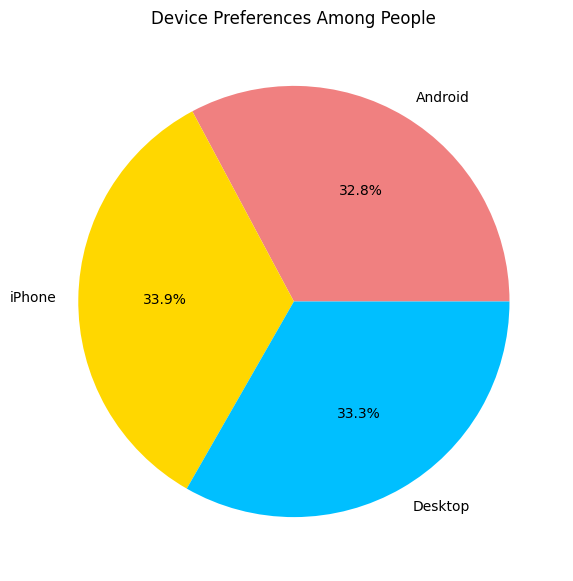

In [65]:
#Analyze devices, which device is the most active?
device_counts = {
    'Android': finalFile['Android'].sum(),
    'iPhone': finalFile['iPhone'].sum(),
    'Desktop': finalFile['Desktop'].sum()
}

# Plot a pie chart
plt.figure(figsize=(7, 7))
plt.pie(device_counts.values(), labels=device_counts.keys(), autopct='%1.1f%%', colors=['lightcoral', 'gold', 'deepskyblue'])
plt.title('Device Preferences Among People')
plt.show()


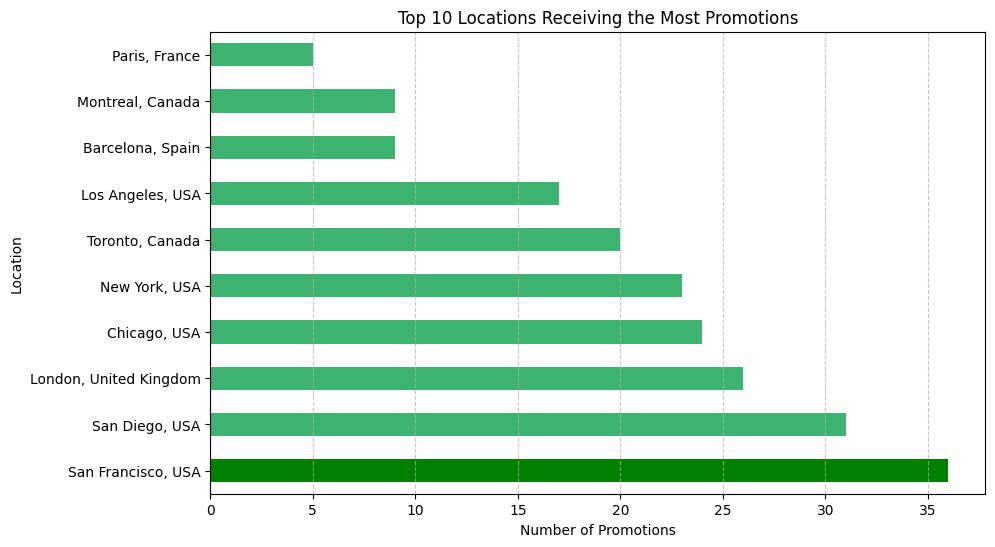

In [66]:
# Identify the most active locations

# Count promotions per location
location_counts = promotionsMerged['Location'].value_counts()

#finding max to distinguish
max_location = location_counts.idxmax()
location_colors = ['green' if location == max_location else 'mediumseagreen' for location in location_counts.index]

#plot
plt.figure(figsize=(10, 6))
location_counts.head(10).plot(kind='barh', color=location_colors)
plt.title('Top 10 Locations Receiving the Most Promotions')
plt.xlabel('Number of Promotions')
plt.ylabel('Location')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

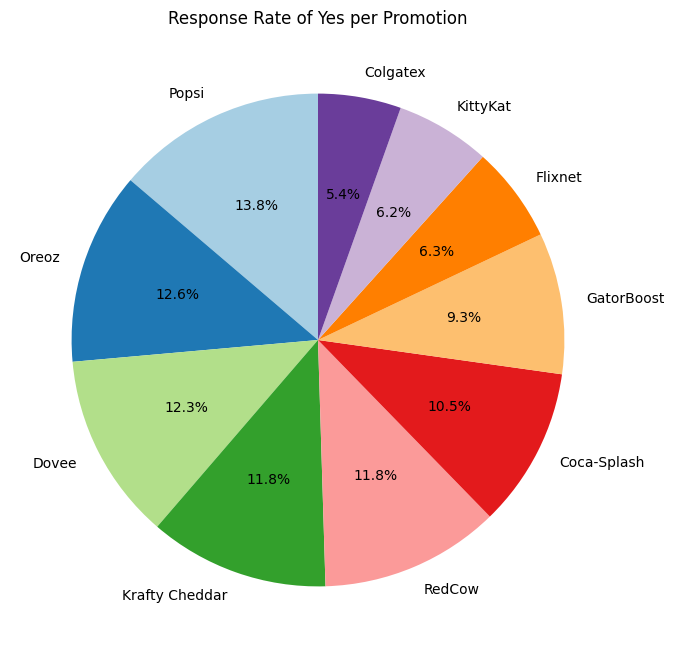

In [67]:
# Finding the response rate of each promotion
total_per_promo = promotionsMerged.groupby('Promotion').size()

# Count responded per promotion
responded_per_promo = promotionsMerged[promotionsMerged['Responded'] == 'Yes'].groupby('Promotion').size()

# Calculate response rate
response_rate = (responded_per_promo / total_per_promo * 100)

# Sort by highest response rate
response_rate = response_rate.sort_values(ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(response_rate, labels=response_rate.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Response Rate of Yes per Promotion')
plt.show()




## 3.1 Suggestions

There should be more focus on not only San Francisco, as it is receives the most promotions, but the US in general as it is consistently in the top countries for most promotions. Venmito should target promotions to these specific locations. To raise percentages of promotions, Venmito should use the data they have, like sending discounts to Colgatex, KittyKat, Flixnet to further promote engagement. Perhaps people don't know about these and just need a small incentive to try it

## Step 3.2: Data Analysis - transcations.xml

<Figure size 1000x500 with 0 Axes>

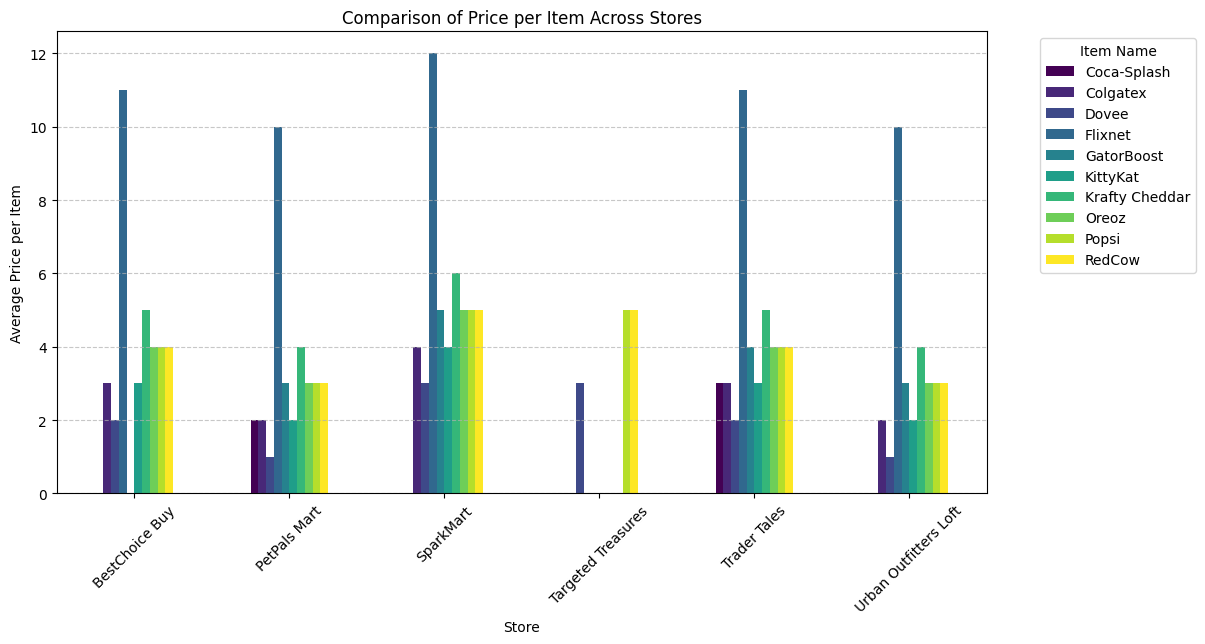

In [68]:
# Comparison of Price_per_item across different stores

xmlFile['Price_per_item'] = pd.to_numeric(xmlFile['Price_per_item'], errors='coerce')
plt.figure(figsize=(10, 5))
avg_price_per_item = xmlFile.groupby(['Store', 'Item_name'])['Price_per_item'].mean().unstack()
avg_price_per_item.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title('Comparison of Price per Item Across Stores')
plt.xlabel('Store')
plt.ylabel('Average Price per Item')
plt.xticks(rotation=45)
plt.legend(title='Item Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

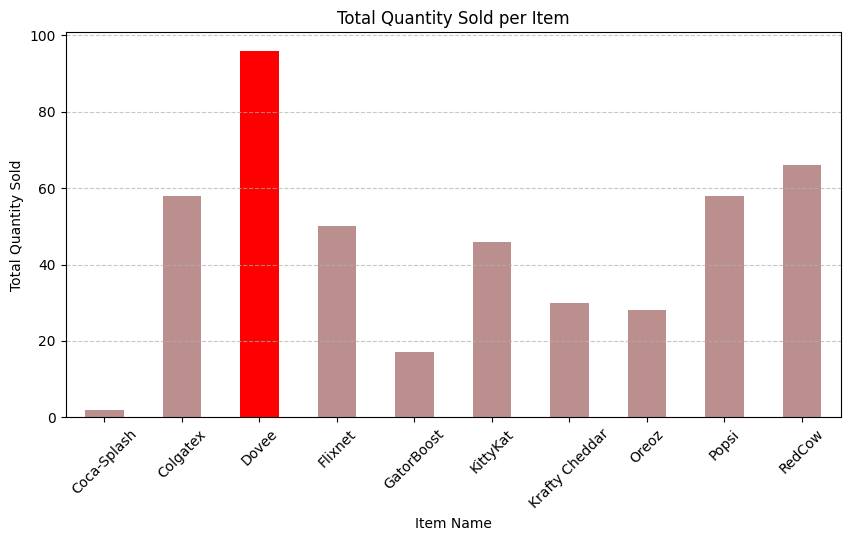

In [69]:
# Plot total quantity sold per Item_name

xmlFile['Quantity'] = pd.to_numeric(xmlFile['Quantity'], errors='coerce')

item_quantity=xmlFile.groupby('Item_name')['Quantity'].sum()
max_item = item_quantity.idxmax()
max_item_colors = ['red' if item == max_item else 'rosybrown' for item in item_quantity.index]

plt.figure(figsize=(10, 5))
item_quantity.plot(kind='bar', color=max_item_colors)
plt.title('Total Quantity Sold per Item')
plt.xlabel('Item Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

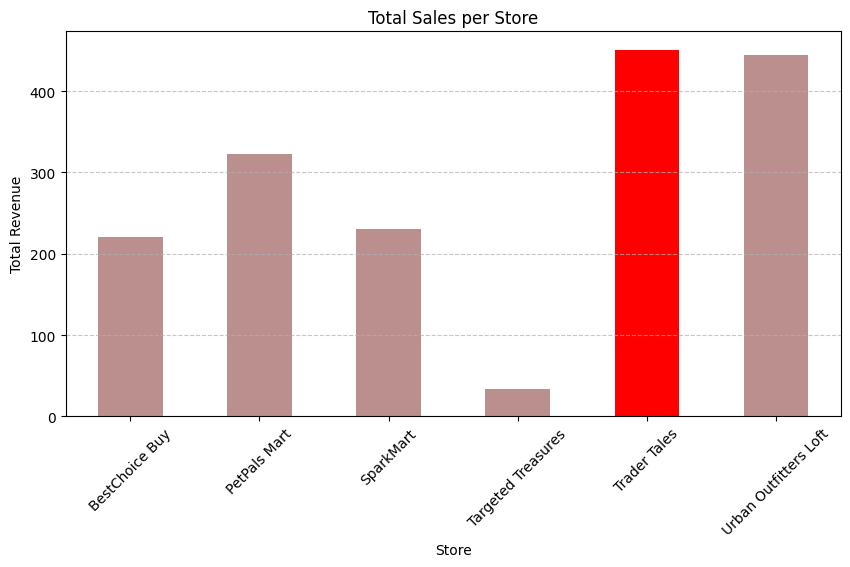

In [70]:
# Group by Store and sum Price
# Plot total sales per Store


xmlFile['Price'] = pd.to_numeric(xmlFile['Price'], errors='coerce')
store_sales = xmlFile.groupby('Store')['Price'].sum()
# Finding the max_store
max_store = store_sales.idxmax()
# Making the max_store easily identifiable 
max_store_colors = ['red' if store == max_store else 'rosybrown' for store in store_sales.index]
plt.figure(figsize=(10, 5))
store_sales.plot(kind='bar', color=max_store_colors)
plt.title('Total Sales per Store')
plt.xlabel('Store')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3.2 Suggestions: 
While Trader Tales is the highest revenue store, the emphasis should be on Urban Outfitters Loft. This store has almost the same amount of revenue but consistently has the lowest sale prices of products in the store, making it a good place to shop on a budget for quality items. This is similar to Aldi's here in the US. Dovee should continueto be sold in the stores as it is consistently the item that is most often sold. Perhaps Urban Outfitters Loft can run a special on the item to pass Trader Tales in total revenue


## Step 3.3: Data Analysis - transfers.csv

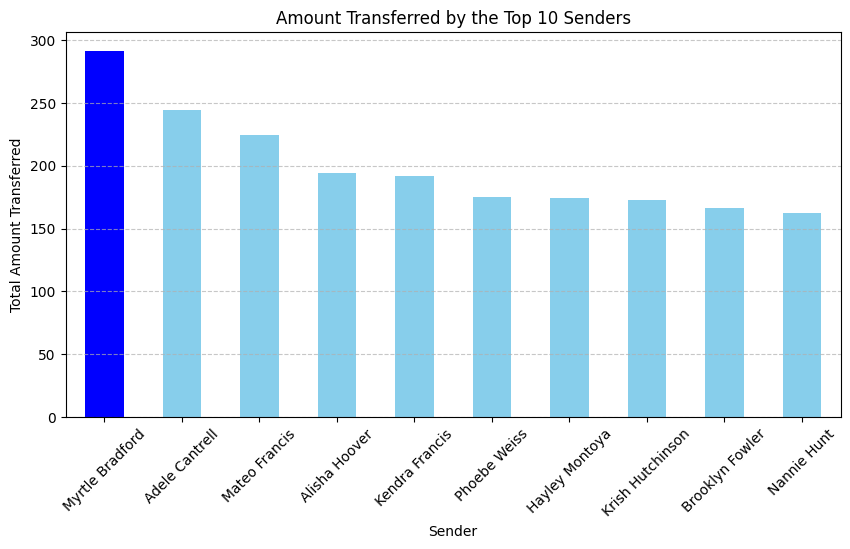

In [71]:
# Plotting the top senders

finalTransfersFile['Amount'] = pd.to_numeric(finalTransfersFile['Amount'], errors='coerce')
finalTransfersFile['Date'] = pd.to_datetime(finalTransfersFile['Date'], errors='coerce')

sender_totals = finalTransfersFile.groupby('Sender_name')['Amount'].sum().sort_values(ascending=False)
top_senders = sender_totals.head(10)
max_sender = top_senders.idxmax()
max_senders_colors = ['blue' if sender == max_sender else 'skyblue' for sender in top_senders.index]

plt.figure(figsize=(10, 5))
top_senders.plot(kind='bar', color=max_senders_colors)
plt.title('Amount Transferred by the Top 10 Senders')
plt.xlabel('Sender')
plt.ylabel('Total Amount Transferred')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

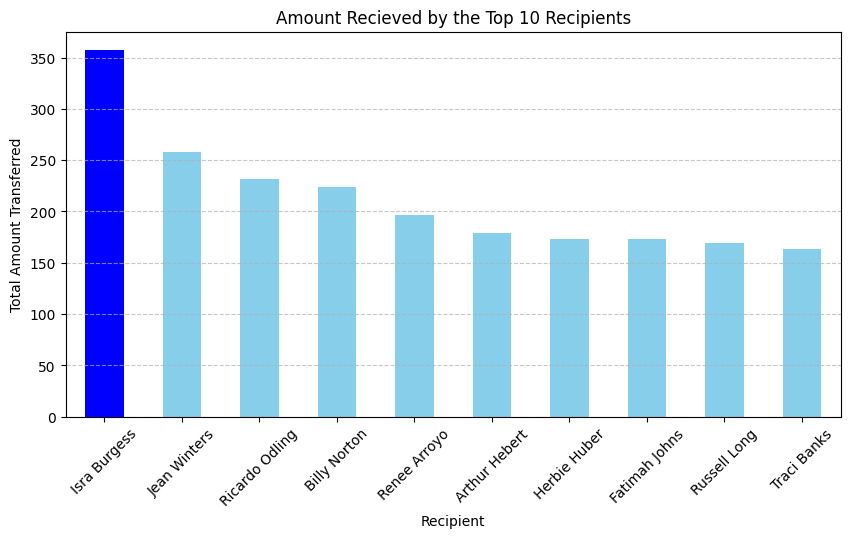

In [72]:
# Plotting the top recipients
recipient_totals = finalTransfersFile.groupby('Recipient_name')['Amount'].sum().sort_values(ascending=False)
top_recipients = recipient_totals.head(10)
max_recipient = top_recipients.idxmax()
max_recipients_colors = ['blue' if recipient == max_recipient else 'skyblue' for recipient in top_recipients.index]

plt.figure(figsize=(10, 5))
top_recipients.plot(kind='bar', color=max_senders_colors)
plt.title('Amount Recieved by the Top 10 Recipients')
plt.xlabel('Recipient')
plt.ylabel('Total Amount Transferred')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

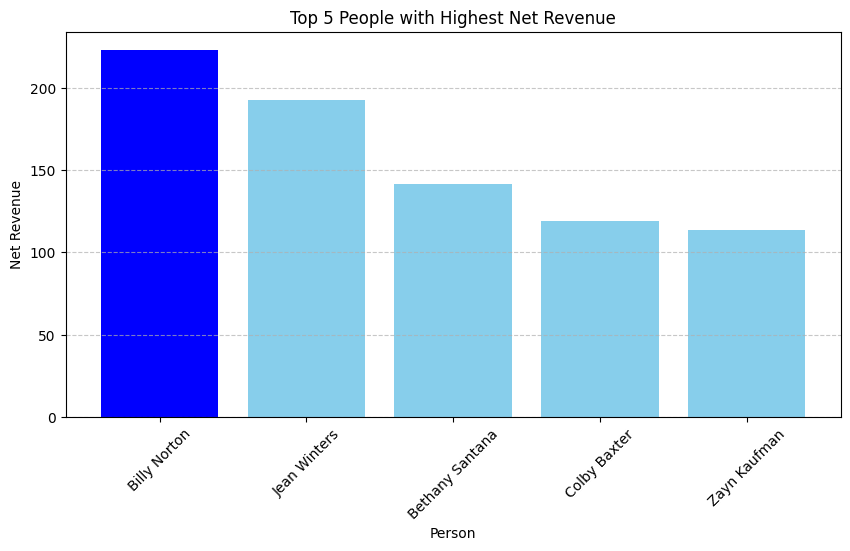

In [73]:

#Calculate total sent and received

total_sent = finalTransfersFile.groupby('Sender_name')['Amount'].sum()
total_received = finalTransfersFile.groupby('Recipient_name')['Amount'].sum()

#Merge into one DataFrame
total_revenue = pd.DataFrame({'Total_Received': total_received, 'Total_Sent': total_sent}).fillna(0)

# Filters to ensure these people have both sent and receieved money
total_revenue = total_revenue[(total_revenue['Total_Received'] > 0) & (total_revenue['Total_Sent'] > 0)]

#calculate total revenue
total_revenue['Net_Revenue'] = total_revenue['Total_Received'] - total_revenue['Total_Sent']
revenue_top_5 = total_revenue.nlargest(5, 'Net_Revenue')
#calculate max_revenue

max_revenue = revenue_top_5['Net_Revenue'].idxmax()

# Highlight the highest bar in blue
revenue_colors = ['blue' if revenue == max_revenue else 'skyblue' for revenue in revenue_top_5.index]


# Plot the top 5 net revenue earners
plt.figure(figsize=(10, 5))
plt.bar(revenue_top_5.index, revenue_top_5['Net_Revenue'], color=revenue_colors)

# Labels and titles
plt.title('Top 5 People with Highest Net Revenue')
plt.xlabel('Person')
plt.ylabel('Net Revenue')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## 3.3 Suggestions
Considering there are some big senders, Venmito can implement a loyalty program where a sender spends some money per month but Venmito has a protection service to insure the integrity of their money, as well perhaps Venmito can cover 1% of the total amount sent